In [1]:
#!/usr/bin/env python
# coding: utf-8

%load_ext autoreload
%autoreload 2



import torch, datetime, click
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
from utils import *
from data_mgmt import get_paths, get_ids

from plot import *

In [30]:
DEVICE = 'cuda'



m = 1
nsub = 1
nsim = 500

nmc = 3
sigma = 0.0

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 10

zero = 'toy'

In [31]:

def noise(obs, _= None, sigma_n = sigma):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}

# Set definitions (should go to click)
systemname = "ngc4414"

# Set utilities

store_path, dataset_path, mre_path, _ = get_paths(dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,zero=zero))

store = swyft.Store.load(path=store_path)
print(f'Store has {len(store)} simulations.')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
config = get_config(systemname, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset = swyft.Dataset(nsim, prior, store, simhook = noise)


Loading existing store.
Store has 445 simulations.
Image has L = 40.


In [40]:
# Train network
print(f'Training {mre_path}!')

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
#         L = L,
    nmc = nmc, 
#         lows = lows,
#         highs = highs,
    marginal_classifier = CustomMarginalClassifier,
    parameter_transform = CustomParameterTransform(nmc, L, lows, highs)
)

mre = swyft.MarginalRatioEstimator(
    marginal_indices = marginal_indices,
    network = network,
    device = DEVICE,
)

_ = mre.train(dataset, max_epochs = max_epochs)

Training ../data/mre/mre_m_1_nsub_1_nsim_500_sigma_0.0_nmc_3.pt!
3
training: lr=5e-05, epoch=10, validation loss=6656.883789


# Predict

In [41]:
npred = 0
entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
store_path, dataset_path, mre_path, pred_path = get_paths(entry)

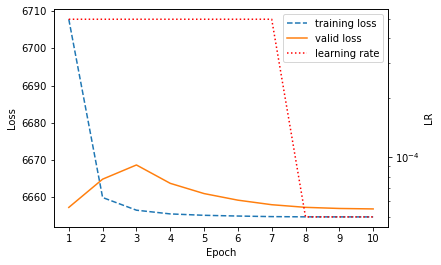

In [43]:
plot_losses(mre, save_name = get_ids(entry)[2])#, title = f'No construction, duration: {duration}')

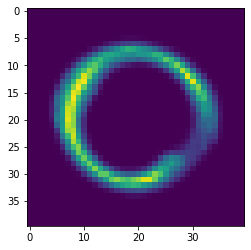

In [53]:
def get_obs(dataset, obs0_i = -1):
    obs0_i = np.random.randint(0, len(dataset)) if obs0_i == -1 else obs0_i

    obs0 = dataset[obs0_i][0]
    v0 = dataset[obs0_i][2]

    obs0['image'] = obs0['image'].unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = v0.unsqueeze(0).to(DEVICE)

    return obs0, v0, obs0_i

def get_empty_and_full_coords(lows, highs, nmc, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmc+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]
    print(ms)

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    coord_full = torch.cat( [torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1) for m in ms] ).reshape(1, -1).to(DEVICE, dtype = torch.float)

    return coord_empty, coord_full

obs0, v0, obs0_i = get_obs(dataset)
targets = mre.network.parameter_transform(v0).squeeze()
target = targets.numpy()
plt_imshow(obs0['image'], y = 4)

In [54]:
coord_empty, coord_full = get_empty_and_full_coords(lows, highs, nmc, L)

[tensor([2.1544e+10, 2.1544e+10, 2.1544e+10,  ..., 2.1544e+10, 2.1544e+10,
        2.1544e+10]), tensor([1.0000e+11, 1.0000e+11, 1.0000e+11,  ..., 1.0000e+11, 1.0000e+11,
        1.0000e+11]), tensor([4.6416e+11, 4.6416e+11, 4.6416e+11,  ..., 4.6416e+11, 4.6416e+11,
        4.6416e+11])]


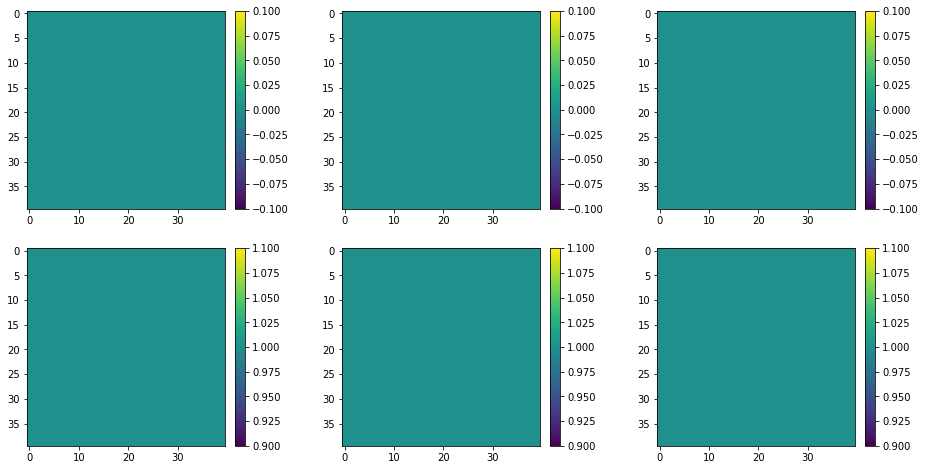

In [52]:
plt_imshow( mre.network.parameter_transform(coord_full).squeeze(), cbar = True , nrows = 2)

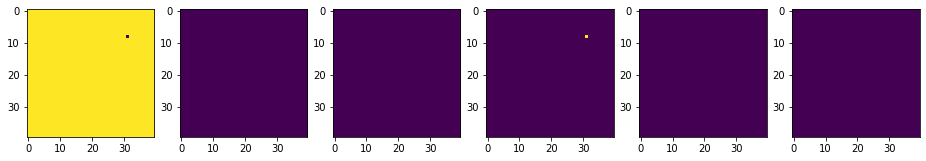

In [45]:
plt_imshow(target, y = 4)

In [77]:
coord_empty, coord_full = get_empty_and_full_coords(lows, highs, nmc, L)

In [78]:
def get_priors(nsub = 1, L = 40, nmc = 1):
    prior = nsub/(L*L)/nmc
    prior0 = 1 - prior
    prior1 = prior
    return prior0, prior1, np.repeat(np.array([prior0, prior1]), nmc) 
prior0, prior1, _ = get_priors()


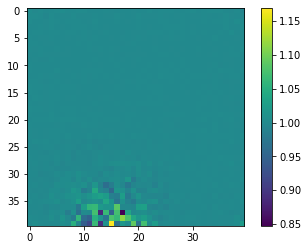

In [79]:
# plt.imshow(np.exp(mre.network(obs0, coord_empty).view(2*nmc, L, L)[0])*prior0 + np.exp(mre.network(obs0, coord_full).view(2*nmc, L, L)[1])*prior1)
plt.imshow(np.exp(mre.network(obs0, coord_empty).view(nmc, L, L)[0])*prior0 + np.exp(mre.network(obs0, coord_full).view(nmc, L, L)[0])*prior1)
plt.colorbar()

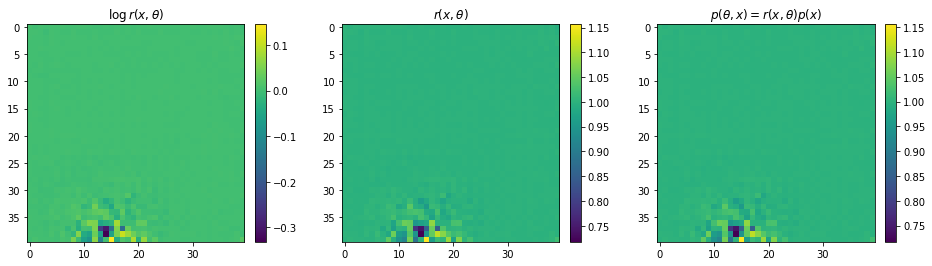

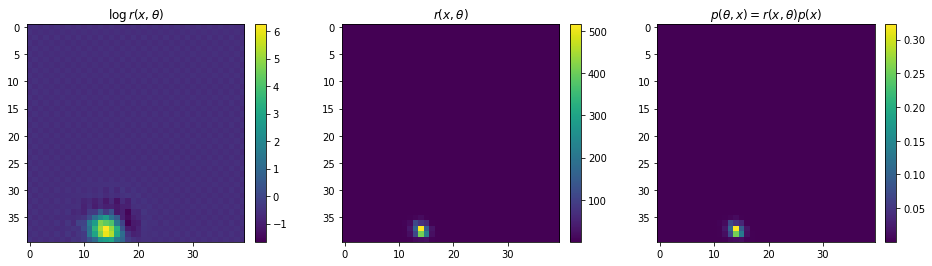

In [80]:
for coord, prior in zip([coord_empty, coord_full], [prior0, prior1]):
    
    
    logratio = mre.network(obs0, coord).view(nmc, L, L)[0]
    
    plt_imshow(
        [logratio, np.exp(logratio), np.exp(logratio)*prior],
        titles = [r'$\log r(x,\theta)$', r'$r(x,\theta)$', r'$p(\theta,x) = r(x,\theta) p(x)$'],
        cbar = True, y = 4)


In [43]:
# for coord, prior in zip([coord_empty, coord_full], [prior0, prior1]):
#     logratio = mre.network(obs0, coord).view(2*nmc, L, L)[0]
    
#     plt_imshow(
#         [logratio, np.exp(logratio), np.exp(logratio)*prior],
#         titles = [r'$\log r(x,\theta)$', r'$r(x,\theta)$', r'$p(\theta,x) = r(x,\theta) p(x)$'],
#         cbar = True, y = 4)
